<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data" data-toc-modified-id="Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Embedding" data-toc-modified-id="Embedding-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Embedding</a></span></li><li><span><a href="#VGGish-model" data-toc-modified-id="VGGish-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>VGGish model</a></span></li><li><span><a href="#YAMNet-model" data-toc-modified-id="YAMNet-model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>YAMNet model</a></span></li><li><span><a href="#1-vs-rest" data-toc-modified-id="1-vs-rest-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>1 vs rest</a></span></li><li><span><a href="#Yam+Vgg" data-toc-modified-id="Yam+Vgg-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Yam+Vgg</a></span></li><li><span><a href="#High-confidence-errors" data-toc-modified-id="High-confidence-errors-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>High confidence errors</a></span><ul class="toc-item"><li><span><a href="#Errors-on-train-set" data-toc-modified-id="Errors-on-train-set-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Errors on train set</a></span></li><li><span><a href="#Errors-on-validation-set" data-toc-modified-id="Errors-on-validation-set-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Errors on validation set</a></span></li></ul></li><li><span><a href="#Subclasses" data-toc-modified-id="Subclasses-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Subclasses</a></span></li></ul></div>

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, Concatenate
import pandas as pd
import numpy as np
from librosa.core import resample, load
from librosa.util import fix_length
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay,
    roc_auc_score, roc_curve, auc
)
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import IPython

# Data

In [2]:
data = pd.read_csv('clean.csv')

In [3]:
all_classes = [c for c in data.columns if c.startswith('class')]
class_count = data[all_classes].idxmax(axis=1).value_counts()
class_count

class_Snare        2149
class_Kick         1560
class_Hat          1297
class_Tom          1255
class_Cymbal        728
class_Clap          314
class_Cowbell       153
class_Conga         121
class_Shaken        108
class_Tambourin      81
class_Bongo          60
class_Agogo          56
class_Clave          54
class_Timbales       49
class_Djembe         20
class_Guiro          17
class_Cajon          12
class_Cuica          10
class_Timpani        10
class_Tabla           9
class_Triangle        8
class_Gong            4
class_Darbuka         4
class_clave           2
dtype: int64

In [4]:
classes_cols = class_count[class_count > 100].index

In [5]:
nb_classes = len(classes_cols)
data = data[data[classes_cols].sum(axis=1) == 1]

In [6]:
data.shape

(7685, 48)

In [7]:
data.head()

,path,filename,dir_1,class_Hat,subclass_Hat_Open,subclass_Hat_Close,subclass_Hat_Foot,class_Bongo,class_Cymbal,subclass_Cymbal_Crash,...,class_clave,dir_2,subclass_Snare_Off,subclass_Snare_On,subclass_Snare_Side,subclass_Snare_Flam,subclass_Snare_Brush,subclass_Cymbal_Other,subclass_Shaken_Other,subclass_None
0,./Samples/200-drum-machines/Yamaha RX-11/MaxV ...,MaxV - RX11 OPHAT2.wav,Yamaha RX-11,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,./Samples/200-drum-machines/Yamaha RX-11/MaxV ...,MaxV - RX11 BD3.wav,Yamaha RX-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,./Samples/200-drum-machines/Yamaha RX-11/MaxV ...,MaxV - RX11 BD2.wav,Yamaha RX-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,./Samples/200-drum-machines/Yamaha RX-11/MaxV ...,MaxV - RX11 CLHAT2.wav,Yamaha RX-11,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,./Samples/200-drum-machines/Yamaha RX-11/MaxV ...,MaxV - RX11 RIDE.wav,Yamaha RX-11,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [8]:
data = data.loc[data['path'] != './Samples/200-drum-machines/Roland JV 1080/MaxV - Guiro.wav']

In [9]:
subclasses_cols = [c for c in data.columns if c.startswith('subclass')]
subclasses = data[subclasses_cols]
subclasses = subclasses.reindex(sorted(subclasses.columns), axis=1)
subclasses.loc[(subclasses.sum(axis=1) == 0), 'subclass_None'] = 1
subclasses = subclasses.fillna(0)
nb_subclasses = len(subclasses.columns)
subclasses_cols = subclasses.columns

In [99]:
subclasses_cols

Index(['subclass_Cymbal_China', 'subclass_Cymbal_Crash',
       'subclass_Cymbal_Other', 'subclass_Cymbal_Ride',
       'subclass_Cymbal_Splash', 'subclass_Hat_Close', 'subclass_Hat_Foot',
       'subclass_Hat_Open', 'subclass_None', 'subclass_Shaken_Cabasa',
       'subclass_Shaken_Maracas', 'subclass_Shaken_Other',
       'subclass_Shaken_Shaker', 'subclass_Snare_Brush', 'subclass_Snare_Flam',
       'subclass_Snare_Off', 'subclass_Snare_On', 'subclass_Snare_Rim',
       'subclass_Snare_Side'],
      dtype='object')

# Embedding

In [10]:
vggish = hub.load('https://tfhub.dev/google/vggish/1')
yamnet = hub.load('https://tfhub.dev/google/yamnet/1')

In [11]:
SR=16000
classes = data[classes_cols]
files = data['path']
vgg_embeddings = []
yam_embeddings = []
for path in tqdm(files):
    sound, _ = load(path, sr=SR)
    sound = fix_length(sound, 1*SR)
    vgg_embeddings.append(vggish(sound))
    _, yam_emb, _ = yamnet(sound)
    yam_embeddings.append(yam_emb[0])

vgg_embeddings = np.stack(vgg_embeddings)
yam_embeddings = np.stack(yam_embeddings)

In [12]:
vgg_embeddings.shape, yam_embeddings.shape

((7685, 1, 128), (7685, 1024))

In [13]:
vgg_embeddings = vgg_embeddings.reshape(-1, 128)
yam_embeddings = yam_embeddings.reshape(-1, 1024)

In [14]:
x_vgg_train, x_vgg_valid, x_yam_train, x_yam_valid, y_train, y_valid, y_train_sub, y_valid_sub = train_test_split(vgg_embeddings, yam_embeddings, classes, subclasses, test_size=0.3, stratify=classes)

In [15]:
x_vgg_train.shape

(5379, 128)

# VGGish model

In [67]:
inputs = Input(shape=(128))
x = Dense(100, activation='relu')(inputs)
x = Dropout(0.4)(x)
x = Dense(50, activation='relu')(x)
x = Dropout(0.4)(x)
outputs = Dense(nb_classes, activation='softmax')(x)

model = Model(inputs, outputs)
model.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense_20 (Dense)             (None, 100)               12900     
_________________________________________________________________
dropout_14 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_15 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 9)                 459       
Total params: 18,409
Trainable params: 18,409
Non-trainable params: 0
_________________________________________________

In [68]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [69]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=classes_cols,
    y=y_train.idxmax(axis=1))

class_weights = dict(zip(range(nb_classes), class_weights))
class_weights

{0: 0.39738475177304966,
 1: 0.5473137973137974,
 2: 0.658223201174743,
 3: 0.6807137433561123,
 4: 1.1741977734119189,
 5: 2.716666666666667,
 6: 5.585669781931464,
 7: 7.031372549019608,
 8: 7.864035087719298}

In [70]:
history = model.fit(x_vgg_train, y_train, epochs=150, class_weight=class_weights, validation_data=(x_vgg_valid, y_valid))

Epoch 1/150
169/169 [==============================] - 0s 3ms/step - loss: 1.8154 - accuracy: 0.3008 - val_loss: 1.3920 - val_accuracy: 0.5520
Epoch 2/150
169/169 [==============================] - 0s 1ms/step - loss: 1.2713 - accuracy: 0.4412 - val_loss: 1.1195 - val_accuracy: 0.5698
Epoch 3/150
169/169 [==============================] - 0s 1ms/step - loss: 1.0260 - accuracy: 0.5072 - val_loss: 0.9791 - val_accuracy: 0.6210
Epoch 4/150
169/169 [==============================] - 0s 1ms/step - loss: 0.9153 - accuracy: 0.5626 - val_loss: 0.9497 - val_accuracy: 0.6409
Epoch 5/150
169/169 [==============================] - 0s 1ms/step - loss: 0.8508 - accuracy: 0.5917 - val_loss: 0.8472 - val_accuracy: 0.6795
Epoch 6/150
169/169 [==============================] - 0s 2ms/step - loss: 0.8071 - accuracy: 0.6170 - val_loss: 0.8257 - val_accuracy: 0.6925
Epoch 7/150
169/169 [==============================] - 0s 1ms/step - loss: 0.7734 - accuracy: 0.6222 - val_loss: 0.8213 - val_accuracy: 0.6856

Epoch 58/150
169/169 [==============================] - 0s 1ms/step - loss: 0.4058 - accuracy: 0.7797 - val_loss: 0.5609 - val_accuracy: 0.7984
Epoch 59/150
169/169 [==============================] - 0s 1ms/step - loss: 0.4208 - accuracy: 0.7765 - val_loss: 0.5921 - val_accuracy: 0.7801
Epoch 60/150
169/169 [==============================] - 0s 1ms/step - loss: 0.4142 - accuracy: 0.7875 - val_loss: 0.5519 - val_accuracy: 0.7918
Epoch 61/150
169/169 [==============================] - 0s 1ms/step - loss: 0.3849 - accuracy: 0.7975 - val_loss: 0.5483 - val_accuracy: 0.8070
Epoch 62/150
169/169 [==============================] - 0s 1ms/step - loss: 0.4039 - accuracy: 0.7931 - val_loss: 0.5522 - val_accuracy: 0.8018
Epoch 63/150
169/169 [==============================] - 0s 1ms/step - loss: 0.4233 - accuracy: 0.7819 - val_loss: 0.5765 - val_accuracy: 0.7879
Epoch 64/150
169/169 [==============================] - 0s 1ms/step - loss: 0.4035 - accuracy: 0.7842 - val_loss: 0.5818 - val_accuracy:

169/169 [==============================] - 0s 2ms/step - loss: 0.3191 - accuracy: 0.8297 - val_loss: 0.5147 - val_accuracy: 0.8183
Epoch 115/150
169/169 [==============================] - 0s 2ms/step - loss: 0.3088 - accuracy: 0.8262 - val_loss: 0.5044 - val_accuracy: 0.8304
Epoch 116/150
169/169 [==============================] - 0s 2ms/step - loss: 0.3016 - accuracy: 0.8297 - val_loss: 0.4935 - val_accuracy: 0.8317
Epoch 117/150
169/169 [==============================] - 0s 2ms/step - loss: 0.3059 - accuracy: 0.8284 - val_loss: 0.5351 - val_accuracy: 0.8200
Epoch 118/150
169/169 [==============================] - 0s 2ms/step - loss: 0.3071 - accuracy: 0.8245 - val_loss: 0.5349 - val_accuracy: 0.8140
Epoch 119/150
169/169 [==============================] - 0s 2ms/step - loss: 0.3154 - accuracy: 0.8265 - val_loss: 0.5052 - val_accuracy: 0.8322
Epoch 120/150
169/169 [==============================] - 0s 1ms/step - loss: 0.3220 - accuracy: 0.8236 - val_loss: 0.5041 - val_accuracy: 0.8239

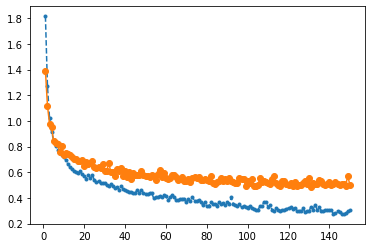

In [71]:
loss = history.history['loss']
epochs = range(1, len(loss) + 1)
val_loss = history.history['val_loss']
plt.plot(epochs, loss, '.--', label='Training loss')
plt.plot(epochs, val_loss, 'o-', label='Validation loss')
plt.show()

In [72]:
y_pred = model.predict(x_vgg_valid)
y_pred_class = np.argmax(y_pred,axis=1).astype(int)
y_valid_class = np.argmax(y_valid.values,axis=1).astype(int)

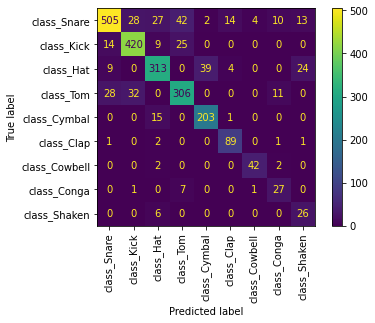

In [73]:
conf_matrix = ConfusionMatrixDisplay(
    confusion_matrix(y_valid_class, y_pred_class),
    display_labels=classes_cols,
)
conf_matrix.plot(xticks_rotation=90);

In [74]:
print(classification_report(y_valid_class, y_pred_class, target_names=classes_cols))

               precision    recall  f1-score   support

  class_Snare       0.91      0.78      0.84       645
   class_Kick       0.87      0.90      0.89       468
    class_Hat       0.84      0.80      0.82       389
    class_Tom       0.81      0.81      0.81       377
 class_Cymbal       0.83      0.93      0.88       219
   class_Clap       0.82      0.95      0.88        94
class_Cowbell       0.89      0.91      0.90        46
  class_Conga       0.53      0.75      0.62        36
 class_Shaken       0.41      0.81      0.54        32

     accuracy                           0.84      2306
    macro avg       0.77      0.85      0.80      2306
 weighted avg       0.85      0.84      0.84      2306



In [75]:
roc_auc_score(y_valid_class, model.predict(x_vgg_valid), average='weighted', multi_class='ovr')

0.9741430230087984

# YAMNet model

In [76]:
inputs = Input(shape=(1024))
x = Dropout(0.4)(inputs)
x = Dense(100, activation='relu')(x)
x = Dropout(0.4)(inputs)
x = Dense(50, activation='relu')(x)
x = Dropout(0.4)(inputs)
outputs = Dense(nb_classes, activation='softmax')(x)

model2 = Model(inputs, outputs)
model2.summary()

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 1024)]            0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 9)                 9225      
Total params: 9,225
Trainable params: 9,225
Non-trainable params: 0
_________________________________________________________________


In [77]:
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [78]:
history = model2.fit(x_yam_train, y_train, epochs=100, validation_data=(x_yam_valid, y_valid))

Epoch 1/100
169/169 [==============================] - 0s 2ms/step - loss: 1.4425 - accuracy: 0.4860 - val_loss: 1.1365 - val_accuracy: 0.5880
Epoch 2/100
169/169 [==============================] - 0s 2ms/step - loss: 1.0849 - accuracy: 0.6102 - val_loss: 0.9711 - val_accuracy: 0.6435
Epoch 3/100
169/169 [==============================] - 0s 1ms/step - loss: 0.9665 - accuracy: 0.6561 - val_loss: 0.8884 - val_accuracy: 0.6752
Epoch 4/100
169/169 [==============================] - 0s 1ms/step - loss: 0.9044 - accuracy: 0.6724 - val_loss: 0.8363 - val_accuracy: 0.6860
Epoch 5/100
169/169 [==============================] - 0s 2ms/step - loss: 0.8691 - accuracy: 0.6830 - val_loss: 0.8063 - val_accuracy: 0.6934
Epoch 6/100
169/169 [==============================] - 0s 2ms/step - loss: 0.8360 - accuracy: 0.6960 - val_loss: 0.7766 - val_accuracy: 0.7125
Epoch 7/100
169/169 [==============================] - 0s 1ms/step - loss: 0.8100 - accuracy: 0.7057 - val_loss: 0.7591 - val_accuracy: 0.7168

Epoch 58/100
169/169 [==============================] - 0s 1ms/step - loss: 0.6193 - accuracy: 0.7697 - val_loss: 0.6298 - val_accuracy: 0.7827
Epoch 59/100
169/169 [==============================] - 0s 1ms/step - loss: 0.6182 - accuracy: 0.7754 - val_loss: 0.6313 - val_accuracy: 0.7819
Epoch 60/100
169/169 [==============================] - 0s 1ms/step - loss: 0.6213 - accuracy: 0.7656 - val_loss: 0.6286 - val_accuracy: 0.7853
Epoch 61/100
169/169 [==============================] - 0s 1ms/step - loss: 0.6077 - accuracy: 0.7797 - val_loss: 0.6268 - val_accuracy: 0.7879
Epoch 62/100
169/169 [==============================] - 0s 1ms/step - loss: 0.6111 - accuracy: 0.7786 - val_loss: 0.6291 - val_accuracy: 0.7836
Epoch 63/100
169/169 [==============================] - 0s 1ms/step - loss: 0.6069 - accuracy: 0.7786 - val_loss: 0.6308 - val_accuracy: 0.7840
Epoch 64/100
169/169 [==============================] - 0s 1ms/step - loss: 0.6063 - accuracy: 0.7693 - val_loss: 0.6252 - val_accuracy:

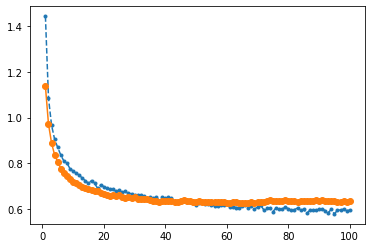

In [79]:
loss = history.history['loss']
epochs = range(1, len(loss) + 1)
val_loss = history.history['val_loss']
plt.plot(epochs, loss, '.--', label='Training loss')
plt.plot(epochs, val_loss, 'o-', label='Validation loss')
plt.show()

In [80]:
y_pred = model2.predict(x_yam_valid)
y_pred_class = np.argmax(y_pred,axis=1).astype(int)

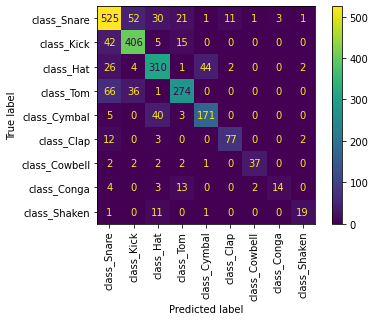

In [81]:
conf_matrix = ConfusionMatrixDisplay(
    confusion_matrix(y_valid_class, y_pred_class),
    display_labels=classes_cols,
)
conf_matrix.plot(xticks_rotation=90);

In [82]:
print(classification_report(y_valid_class, y_pred_class, target_names=classes_cols))

               precision    recall  f1-score   support

  class_Snare       0.77      0.81      0.79       645
   class_Kick       0.81      0.87      0.84       468
    class_Hat       0.77      0.80      0.78       389
    class_Tom       0.83      0.73      0.78       377
 class_Cymbal       0.78      0.78      0.78       219
   class_Clap       0.86      0.82      0.84        94
class_Cowbell       0.93      0.80      0.86        46
  class_Conga       0.82      0.39      0.53        36
 class_Shaken       0.79      0.59      0.68        32

     accuracy                           0.79      2306
    macro avg       0.82      0.73      0.76      2306
 weighted avg       0.80      0.79      0.79      2306



In [83]:
roc_auc_score(y_valid_class, model2.predict(x_yam_valid), average='weighted', multi_class='ovr')

0.9604248633864164

# 1 vs rest

In [ ]:
model.trainable = False
inputs = model.inputs
x = model.get_layer(index=-3).output
outputs = Dense(1, activation='sigmoid')(x)
model3 = Model(inputs, outputs)
model3.summary()
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
total = len(y_train['class_Shaken'])
positive = (y_train['class_Shaken'] == 1).sum()
negative = (y_train['class_Shaken'] == 0).sum()
weights = {0:(1 / negative)*(total)/2.0 ,1:(1 / positive)*(total)/2.0}
history = model3.fit(x_vgg_train, y_train['class_Shaken'], epochs=100, class_weight=weights, validation_data=(x_vgg_valid, y_valid['class_Shaken']))

In [ ]:
y_pred = model3.predict(x_vgg_valid)
y_pred_class = (y_pred > 0.5).astype(int)
conf_matrix = ConfusionMatrixDisplay(
    confusion_matrix(y_valid['class_Shaken'], y_pred_class),
)
conf_matrix.plot(xticks_rotation=90);

In [ ]:
print(classification_report(y_valid['class_Shaken'], y_pred_class))

In [ ]:
fpr, tpr, _ = roc_curve(y_valid['class_Shaken'], model3.predict(x_vgg_valid))
roc_auc = auc(fpr, tpr)
print(roc_auc)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Yam+Vgg

In [89]:
vgg_input = Input(shape=(128))
yam_input = Input(shape=(1024))
yam = Dropout(0.5)(yam_input)
x = Concatenate()([vgg_input,yam])
x = Dense(100, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(50, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(nb_classes, activation='softmax')(x)

model_vgg_yam = Model([vgg_input,yam_input], outputs)
model_vgg_yam.summary()

Model: "functional_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 1024)]       0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
dropout_22 (Dropout)            (None, 1024)         0           input_13[0][0]                   
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 1152)         0           input_12[0][0]                   
                                                                 dropout_22[0][0]     

In [90]:
model_vgg_yam.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model_vgg_yam.fit([x_vgg_train, x_yam_train], y_train, epochs=100, class_weight=class_weights, validation_data=([x_vgg_valid, x_yam_valid], y_valid))

Epoch 1/100
169/169 [==============================] - 1s 3ms/step - loss: 1.9704 - accuracy: 0.2551 - val_loss: 1.4440 - val_accuracy: 0.5195
Epoch 2/100
169/169 [==============================] - 0s 2ms/step - loss: 1.4032 - accuracy: 0.4118 - val_loss: 1.1032 - val_accuracy: 0.5863
Epoch 3/100
169/169 [==============================] - 0s 3ms/step - loss: 1.1325 - accuracy: 0.4815 - val_loss: 0.8952 - val_accuracy: 0.6687
Epoch 4/100
169/169 [==============================] - 0s 2ms/step - loss: 1.0214 - accuracy: 0.5285 - val_loss: 0.8430 - val_accuracy: 0.6817
Epoch 5/100
169/169 [==============================] - 0s 3ms/step - loss: 0.9503 - accuracy: 0.5594 - val_loss: 0.8781 - val_accuracy: 0.6687
Epoch 6/100
169/169 [==============================] - 0s 2ms/step - loss: 0.8776 - accuracy: 0.5936 - val_loss: 0.8132 - val_accuracy: 0.6977
Epoch 7/100
169/169 [==============================] - 0s 3ms/step - loss: 0.8336 - accuracy: 0.6103 - val_loss: 0.7548 - val_accuracy: 0.7181

Epoch 58/100
169/169 [==============================] - 0s 3ms/step - loss: 0.4500 - accuracy: 0.7797 - val_loss: 0.5030 - val_accuracy: 0.8239
Epoch 59/100
169/169 [==============================] - 0s 3ms/step - loss: 0.4307 - accuracy: 0.7803 - val_loss: 0.5164 - val_accuracy: 0.8144
Epoch 60/100
169/169 [==============================] - 0s 3ms/step - loss: 0.4165 - accuracy: 0.7899 - val_loss: 0.5451 - val_accuracy: 0.8122
Epoch 61/100
169/169 [==============================] - 0s 3ms/step - loss: 0.4388 - accuracy: 0.7842 - val_loss: 0.5215 - val_accuracy: 0.8161
Epoch 62/100
169/169 [==============================] - 0s 3ms/step - loss: 0.4297 - accuracy: 0.7903 - val_loss: 0.5284 - val_accuracy: 0.8148
Epoch 63/100
169/169 [==============================] - 0s 3ms/step - loss: 0.4243 - accuracy: 0.7923 - val_loss: 0.5198 - val_accuracy: 0.8166
Epoch 64/100
169/169 [==============================] - 1s 3ms/step - loss: 0.4398 - accuracy: 0.7892 - val_loss: 0.5237 - val_accuracy:

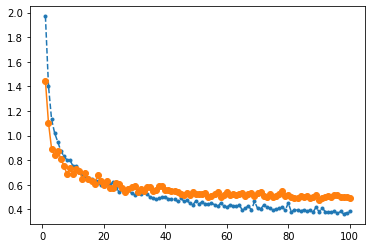

In [91]:
loss = history.history['loss']
epochs = range(1, len(loss) + 1)
val_loss = history.history['val_loss']
plt.plot(epochs, loss, '.--', label='Training loss')
plt.plot(epochs, val_loss, 'o-', label='Validation loss')
plt.show()

               precision    recall  f1-score   support

  class_Snare       0.92      0.80      0.86       645
   class_Kick       0.91      0.92      0.91       468
    class_Hat       0.85      0.81      0.83       389
    class_Tom       0.84      0.82      0.83       377
 class_Cymbal       0.84      0.89      0.86       219
   class_Clap       0.81      0.93      0.87        94
class_Cowbell       0.91      0.87      0.89        46
  class_Conga       0.38      0.83      0.52        36
 class_Shaken       0.42      0.84      0.56        32

     accuracy                           0.85      2306
    macro avg       0.76      0.86      0.79      2306
 weighted avg       0.86      0.85      0.85      2306



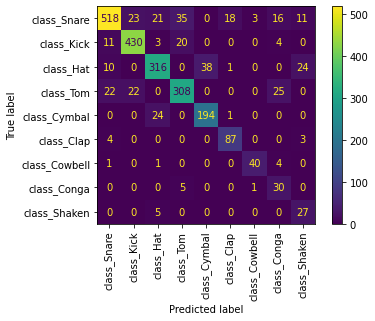

In [92]:
y_pred = model_vgg_yam.predict([x_vgg_valid, x_yam_valid])
y_pred_class = np.argmax(y_pred,axis=1).astype(int)
conf_matrix = ConfusionMatrixDisplay(
    confusion_matrix(y_valid_class, y_pred_class),
    display_labels=classes_cols,
)
conf_matrix.plot(xticks_rotation=90);
print(classification_report(y_valid_class, y_pred_class, target_names=classes_cols))

In [93]:
roc_auc_score(y_valid_class, model_vgg_yam.predict([x_vgg_valid, x_yam_valid]), average='weighted', multi_class='ovr')

0.9764855462264623

# High confidence errors

In [37]:
def show_errors(data, y, y_pred):
    y_class = np.argmax(y.values,axis=1).astype(int)
    for i in range(nb_classes):
        for j in range(nb_classes):
            if i == j:
                continue
            true_index = np.where(y_class==i)[0]
            pred_index = np.where(np.argmax(y_pred,axis=1).astype(int) == j)[0]
            index = list(set(true_index.tolist()) & set(pred_index.tolist()))
            if (len(index)==0):
                continue
            confidence = y_pred[index,j]
            index = index[np.argmax(confidence)]
            confidence = y_pred[index,j]
            index = y.iloc[[index]].index
            print(f'true: {classes_cols[i]}')
            print(f'pred: {classes_cols[j]}')
            print(f'confidence: {confidence}')
            path = data.loc[index, 'path'].values[0]
            print(path)
            sound, sr = load(path)
            IPython.display.display(IPython.display.Audio(sound, rate=sr, autoplay=False))    

## Errors on train set

In [38]:
show_errors(data, y_train, model_vgg_yam.predict([x_vgg_train, x_yam_train]))

true: class_Snare
pred: class_Kick
confidence: 0.9952988028526306
./Samples/wavegan-drums/train/Snare_01175.wav


true: class_Snare
pred: class_Hat
confidence: 0.9808921217918396
./Samples/wavegan-drums/train/Snare_01101.wav


true: class_Snare
pred: class_Tom
confidence: 0.8872454166412354
./Samples/wavegan-drums/train/Snare_00530.wav


true: class_Snare
pred: class_Cymbal
confidence: 0.7741360664367676
./Samples/wavegan-drums/train/Snare_00291.wav


true: class_Snare
pred: class_Clap
confidence: 0.9685805439949036
./Samples/wavegan-drums/train/Snare_02345.wav


true: class_Snare
pred: class_Cowbell
confidence: 0.9992092251777649
./Samples/200-drum-machines/Jomox Xbase-09/Snare02.wav


true: class_Snare
pred: class_Conga
confidence: 0.816929817199707
./Samples/200-drum-machines/Electro Harmonix Drm32/MaxV - Rim.wav


true: class_Snare
pred: class_Shaken
confidence: 0.9986108541488647
./Samples/wavegan-drums/train/Snare_00609.wav


true: class_Kick
pred: class_Snare
confidence: 0.6680356860160828
./Samples/wavegan-drums/train/Kick_01837.wav


true: class_Kick
pred: class_Hat
confidence: 0.43911486864089966
./Samples/wavegan-drums/train/Kick_01398.wav


true: class_Kick
pred: class_Tom
confidence: 0.809272825717926
./Samples/wavegan-drums/train/Snare_01872.wav


true: class_Hat
pred: class_Snare
confidence: 0.4752098023891449
./Samples/wavegan-drums/train/Hat_00821.wav


true: class_Hat
pred: class_Kick
confidence: 0.460601806640625
./Samples/Hydrogen/HardElectro1/Hard_CHH_02.flac


true: class_Hat
pred: class_Cymbal
confidence: 0.7305523753166199
./Samples/200-drum-machines/Roland D-70/MaxV - OP-HIHAT.wav


true: class_Hat
pred: class_Clap
confidence: 0.6727597117424011
./Samples/200-drum-machines/Casio PT-30/MaxV - HH Cl.wav


true: class_Hat
pred: class_Shaken
confidence: 0.9504070281982422
./Samples/musicradar-essential-drumkit-samples/Foley Kit/Foley Fizz Hat 01.wav


true: class_Tom
pred: class_Snare
confidence: 0.7775262594223022
./Samples/200-drum-machines/Simmons SD-8/MaxV - TOM_06.wav


true: class_Tom
pred: class_Kick
confidence: 0.8425883054733276
./Samples/wavegan-drums/train/Tom_01054.wav


true: class_Tom
pred: class_Hat
confidence: 0.8325604200363159
./Samples/wavegan-drums/test/Tom_00104.wav


true: class_Tom
pred: class_Conga
confidence: 0.9902128577232361
./Samples/200-drum-machines/Roland Tr-808/TR-808Tom07.wav


true: class_Cymbal
pred: class_Hat
confidence: 0.636603593826294
./Samples/200-drum-machines/Acetone Rhythm Ace/MaxV - Cymbal.wav


## Errors on validation set

In [39]:
show_errors(data, y_valid, model_vgg_yam.predict([x_vgg_valid, x_yam_valid]))

true: class_Snare
pred: class_Kick
confidence: 0.9991201758384705
./Samples/wavegan-drums/train/Snare_01444.wav


true: class_Snare
pred: class_Hat
confidence: 1.0
./Samples/200-drum-machines/KorgMP7/Rimshot.wav


true: class_Snare
pred: class_Tom
confidence: 0.9859820604324341
./Samples/musicradar-drum-samples/Drum Kits/Kit 11 - Vinyl/CYCdh_VinylK4-Snr01.wav


true: class_Snare
pred: class_Cymbal
confidence: 0.9221426248550415
./Samples/200-drum-machines/Yamaha SY22/Tmborimsy90.wav


true: class_Snare
pred: class_Clap
confidence: 0.9995008707046509
./Samples/200-drum-machines/Korg prophecy/MaxV - KR - Snaredrum 04.wav


true: class_Snare
pred: class_Cowbell
confidence: 0.9685109257698059
./Samples/wavegan-drums/train/Snare_01725.wav


true: class_Snare
pred: class_Conga
confidence: 0.9344125390052795
./Samples/200-drum-machines/Roland TR-55/MaxV - Rim.wav


true: class_Snare
pred: class_Shaken
confidence: 0.9592128396034241
./Samples/200-drum-machines/mercure_drums/p-rim1.wav


true: class_Kick
pred: class_Snare
confidence: 0.8576277494430542
./Samples/musicradar-essential-drumkit-samples/Chip Tune Kit/ChipTune Kick 02.wav


true: class_Kick
pred: class_Hat
confidence: 0.6685910224914551
./Samples/wavegan-drums/train/Kick_01007.wav


true: class_Kick
pred: class_Tom
confidence: 0.9996166229248047
./Samples/musicradar-essential-drumkit-samples/80s Digital Kit/80s Digital Kick 02.wav


true: class_Kick
pred: class_Conga
confidence: 0.9728604555130005
./Samples/wavegan-drums/train/Kick_01050.wav


true: class_Hat
pred: class_Snare
confidence: 0.9936403632164001
./Samples/Hydrogen/ForzeeStereo/HiHatFoot-2.wav


true: class_Hat
pred: class_Cymbal
confidence: 0.999995231628418
./Samples/Hydrogen/Lightning1024/08-HiHatON-11.wav


true: class_Hat
pred: class_Clap
confidence: 0.7139875888824463
./Samples/wavegan-drums/train/Hat_02181.wav


true: class_Hat
pred: class_Shaken
confidence: 0.9975548386573792
./Samples/Hydrogen/3355606kit/dr55hat.wav


true: class_Tom
pred: class_Snare
confidence: 0.9987815022468567
./Samples/wavegan-drums/train/Tom_02315.wav


true: class_Tom
pred: class_Kick
confidence: 0.9999998807907104
./Samples/200-drum-machines/Coron Drum Synce DS-7/coron-ds7-tom1.wav


true: class_Tom
pred: class_Conga
confidence: 0.989697277545929
./Samples/wavegan-drums/valid/Tom_00212.wav


true: class_Cymbal
pred: class_Hat
confidence: 0.9970135688781738
./Samples/musicradar-drum-samples/Drum Kits/Kurzweil Kit 07/CYCdh_Kurz07-RevCrash02.wav


true: class_Cymbal
pred: class_Clap
confidence: 0.9548836350440979
./Samples/200-drum-machines/Casio PT-30/MaxV - Cymbal.wav


true: class_Clap
pred: class_Snare
confidence: 0.5713686943054199
./Samples/musicradar-drum-samples/Drum Kits/Kit 16 - Electro/CYCdh_ElecK06-Clap02.wav


true: class_Clap
pred: class_Shaken
confidence: 0.9106409549713135
./Samples/wavegan-drums/train/Snare_01188.wav


true: class_Cowbell
pred: class_Conga
confidence: 0.93756103515625
./Samples/200-drum-machines/Gulbransen/MaxV - Cowbell.wav


true: class_Conga
pred: class_Snare
confidence: 0.2680016756057739
./Samples/200-drum-machines/Farfisa/MaxV - Conga.wav


true: class_Conga
pred: class_Tom
confidence: 0.9950730204582214
./Samples/200-drum-machines/Kawai R-100/MaxV - CONGLCH3.wav


true: class_Conga
pred: class_Cowbell
confidence: 0.9901526570320129
./Samples/200-drum-machines/Korg SR-120/MaxV - Conga Lo.wav


true: class_Conga
pred: class_Shaken
confidence: 0.43013253808021545
./Samples/200-drum-machines/Wurlitzer Swinging Rhythm/MaxV - Conga Hi.wav


true: class_Shaken
pred: class_Hat
confidence: 0.9803892970085144
./Samples/200-drum-machines/Roland MC303/MaxV - Shaketam.wav


# Subclasses

In [40]:
subclasses_cols

Index(['subclass_Cymbal_China', 'subclass_Cymbal_Crash',
       'subclass_Cymbal_Other', 'subclass_Cymbal_Ride',
       'subclass_Cymbal_Splash', 'subclass_Hat_Close', 'subclass_Hat_Foot',
       'subclass_Hat_Open', 'subclass_None', 'subclass_Shaken_Cabasa',
       'subclass_Shaken_Maracas', 'subclass_Shaken_Other',
       'subclass_Shaken_Shaker', 'subclass_Snare_Brush', 'subclass_Snare_Flam',
       'subclass_Snare_Off', 'subclass_Snare_On', 'subclass_Snare_Rim',
       'subclass_Snare_Side'],
      dtype='object')

In [41]:
classes_cols.get_loc("class_Snare")

0

In [147]:
def create_class_subclass_model():
    vgg_input = Input(shape=(128))
    yam_input = Input(shape=(1024))
    yam = Dropout(0.3)(yam_input)
    x = Concatenate()([vgg_input,yam])
    x = Dense(100, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(50, activation='relu')(x)
    x = Dropout(0.3)(x)
    class_output = Dense(nb_classes, activation='softmax', name="class")(x)
    
#     x = Dense(30, activation='relu')(x)
#     x = tf.keras.layers.Concatenate(axis=-1)([x,class_output])
#     x = Dropout(0.3)(x)
#     subclass_output = Dense(nb_subclasses, activation='softmax', name="subclass")(x)
    
    class_outputs = tf.split(class_output, nb_classes, axis=-1)
#     subclass_output = Dense(nb_subclasses, activation='softmax')(x)
    x = Dense(30, activation='relu')(x)
    x = Dropout(0.3)(x)
   
    snare_id = classes_cols.get_loc("class_Snare")
    snare_size = len([ c for c in subclasses_cols if c.startswith('subclass_Snare')])
    snare_sub = tf.multiply(Dense(snare_size, activation='softmax')(x), tf.repeat(class_outputs[snare_id],snare_size,axis=1))
    
    hat_id = classes_cols.get_loc("class_Hat")
    hat_size = len([ c for c in subclasses_cols if c.startswith('subclass_Hat')])
    hat_sub = tf.multiply(Dense(hat_size, activation='softmax')(x), class_outputs[hat_id][:tf.newaxis])
    
    cym_id = classes_cols.get_loc("class_Cymbal")
    cym_size = len([ c for c in subclasses_cols if c.startswith('subclass_Cymbal')])
    cym_sub = tf.multiply(Dense(cym_size, activation='softmax')(x), class_outputs[cym_id][:tf.newaxis])
    
    sha_id = classes_cols.get_loc("class_Shaken")
    sha_size = len([ c for c in subclasses_cols if c.startswith('subclass_Shaken')])
    sha_sub = tf.multiply(Dense(sha_size, activation='softmax')(x), class_outputs[sha_id][:tf.newaxis])
    
    none_ids = list(range(len(classes_cols)))
    none_output = []
    for i in range(len(classes_cols)):
        if i not in [snare_id, hat_id, cym_id, sha_id]:
            none_output.append(class_outputs[i])
    none_concat = tf.stack(none_output, axis=2, name='concat_other')
    none_output = tf.reduce_sum(none_concat,axis=2)
#     none_sub = tf.multiply(Dense(1)(x), none_output)
    none_sub = none_output
    
    
    
    subclass_output = tf.concat([cym_sub, hat_sub, none_sub, sha_sub, snare_sub],1)
    subclass_output = tf.keras.layers.Activation('softmax', name="subclass")(subclass_output)
#     return Model([vgg_input,yam_input],none_sub)
    return Model([vgg_input,yam_input], [class_output,subclass_output])



In [148]:
model_sub = create_class_subclass_model()
model_sub.summary()

Model: "functional_41"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_49 (InputLayer)           [(None, 1024)]       0                                            
__________________________________________________________________________________________________
input_48 (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
dropout_93 (Dropout)            (None, 1024)         0           input_49[0][0]                   
__________________________________________________________________________________________________
concatenate_21 (Concatenate)    (None, 1152)         0           input_48[0][0]                   
                                                                 dropout_93[0][0]     

In [149]:
import tensorflow.keras.backend as K
from itertools import product
def weighted_categorical_crossentropy(y_true, y_pred, weights):
    nb_cl = len(weights)
    final_mask = K.zeros_like(y_pred[:, 0])
    y_pred_max = K.max(y_pred, axis=1)
    y_pred_max = K.reshape(y_pred_max, (K.shape(y_pred)[0], 1))
    y_pred_max_mat = K.cast(K.equal(y_pred, y_pred_max), K.floatx())
    for c_p, c_t in product(range(nb_cl), range(nb_cl)):
        final_mask += (weights[c_t] * y_pred_max_mat[:, c_p] * y_true[:, c_t])
    return K.categorical_crossentropy(y_pred, y_true) * final_mask


In [150]:
subclass_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=subclasses_cols,
    y=y_train_sub.idxmax(axis=1))

subclass_weights = dict(zip(range(nb_subclasses), subclass_weights))
subclass_weights

{0: 9.132427843803056,
 1: 1.3481203007518796,
 2: 4.566213921901528,
 3: 1.54702329594478,
 4: 12.308924485125859,
 5: 1.1945369753497668,
 6: 11.796052631578947,
 7: 0.4375660945253396,
 8: 0.11885191568341509,
 9: 12.868421052631579,
 10: 31.45614035087719,
 11: 25.736842105263158,
 12: 8.326625386996904,
 13: 94.36842105263158,
 14: 56.62105263157895,
 15: 18.873684210526317,
 16: 0.21286110011871784,
 17: 2.2117598684210527,
 18: 12.308924485125859}

In [151]:
from functools import partial
class_cce = partial(weighted_categorical_crossentropy, weights=class_weights)
class_cce.__name__ = 'class'
subclass_cce = partial(weighted_categorical_crossentropy, weights=subclass_weights)
subclass_cce.__name__ = 'subclass'
model_sub.compile(optimizer='adam', loss=[class_cce,subclass_cce], metrics=['accuracy'])
history = model_sub.fit([x_vgg_train, x_yam_train], [y_train, y_train_sub], epochs=100, validation_data=([x_vgg_valid, x_yam_valid], [y_valid, y_valid_sub]))

Epoch 1/100
169/169 [==============================] - 4s 23ms/step - loss: 25.1643 - class_loss: 9.9649 - subclass_loss: 15.1994 - class_accuracy: 0.3324 - subclass_accuracy: 0.4562 - val_loss: 21.6803 - val_class_loss: 6.4494 - val_subclass_loss: 15.2308 - val_class_accuracy: 0.4970 - val_subclass_accuracy: 0.5186
Epoch 2/100
169/169 [==============================] - 1s 4ms/step - loss: 21.6258 - class_loss: 6.4927 - subclass_loss: 15.1332 - class_accuracy: 0.4834 - subclass_accuracy: 0.5129 - val_loss: 20.3346 - val_class_loss: 5.1221 - val_subclass_loss: 15.2124 - val_class_accuracy: 0.5637 - val_subclass_accuracy: 0.5724
Epoch 3/100
169/169 [==============================] - 1s 4ms/step - loss: 20.3950 - class_loss: 5.2754 - subclass_loss: 15.1195 - class_accuracy: 0.5752 - subclass_accuracy: 0.5648 - val_loss: 19.5874 - val_class_loss: 4.4024 - val_subclass_loss: 15.1851 - val_class_accuracy: 0.6370 - val_subclass_accuracy: 0.6036
Epoch 4/100
169/169 [===========================

Epoch 27/100
169/169 [==============================] - 1s 4ms/step - loss: 17.4270 - class_loss: 2.4229 - subclass_loss: 15.0041 - class_accuracy: 0.7830 - subclass_accuracy: 0.6732 - val_loss: 17.8374 - val_class_loss: 2.7209 - val_subclass_loss: 15.1165 - val_class_accuracy: 0.8040 - val_subclass_accuracy: 0.6856
Epoch 28/100
169/169 [==============================] - 1s 4ms/step - loss: 17.3568 - class_loss: 2.3582 - subclass_loss: 14.9986 - class_accuracy: 0.8024 - subclass_accuracy: 0.6830 - val_loss: 17.7295 - val_class_loss: 2.6362 - val_subclass_loss: 15.0933 - val_class_accuracy: 0.7962 - val_subclass_accuracy: 0.6826
Epoch 29/100
169/169 [==============================] - 1s 4ms/step - loss: 17.2577 - class_loss: 2.2555 - subclass_loss: 15.0022 - class_accuracy: 0.8011 - subclass_accuracy: 0.6808 - val_loss: 17.7876 - val_class_loss: 2.6933 - val_subclass_loss: 15.0942 - val_class_accuracy: 0.8014 - val_subclass_accuracy: 0.6852
Epoch 30/100
169/169 [========================

Epoch 53/100
169/169 [==============================] - 1s 4ms/step - loss: 16.9731 - class_loss: 1.9810 - subclass_loss: 14.9921 - class_accuracy: 0.8156 - subclass_accuracy: 0.6890 - val_loss: 17.5468 - val_class_loss: 2.4604 - val_subclass_loss: 15.0864 - val_class_accuracy: 0.8265 - val_subclass_accuracy: 0.7008
Epoch 54/100
169/169 [==============================] - 1s 4ms/step - loss: 16.8014 - class_loss: 1.8195 - subclass_loss: 14.9819 - class_accuracy: 0.8375 - subclass_accuracy: 0.6996 - val_loss: 17.5408 - val_class_loss: 2.4491 - val_subclass_loss: 15.0917 - val_class_accuracy: 0.8161 - val_subclass_accuracy: 0.6882
Epoch 55/100
169/169 [==============================] - 1s 4ms/step - loss: 16.8612 - class_loss: 1.8734 - subclass_loss: 14.9878 - class_accuracy: 0.8312 - subclass_accuracy: 0.6912 - val_loss: 17.5916 - val_class_loss: 2.4932 - val_subclass_loss: 15.0984 - val_class_accuracy: 0.7953 - val_subclass_accuracy: 0.6756
Epoch 56/100
169/169 [========================

Epoch 79/100
169/169 [==============================] - 1s 4ms/step - loss: 16.5967 - class_loss: 1.6148 - subclass_loss: 14.9818 - class_accuracy: 0.8542 - subclass_accuracy: 0.7044 - val_loss: 17.5517 - val_class_loss: 2.4709 - val_subclass_loss: 15.0808 - val_class_accuracy: 0.8465 - val_subclass_accuracy: 0.7025
Epoch 80/100
169/169 [==============================] - 1s 4ms/step - loss: 16.6856 - class_loss: 1.7005 - subclass_loss: 14.9850 - class_accuracy: 0.8466 - subclass_accuracy: 0.7024 - val_loss: 17.3674 - val_class_loss: 2.2856 - val_subclass_loss: 15.0818 - val_class_accuracy: 0.8382 - val_subclass_accuracy: 0.7034
Epoch 81/100
169/169 [==============================] - 1s 4ms/step - loss: 16.6206 - class_loss: 1.6522 - subclass_loss: 14.9684 - class_accuracy: 0.8397 - subclass_accuracy: 0.7007 - val_loss: 17.5603 - val_class_loss: 2.4768 - val_subclass_loss: 15.0835 - val_class_accuracy: 0.8287 - val_subclass_accuracy: 0.6908
Epoch 82/100
169/169 [========================

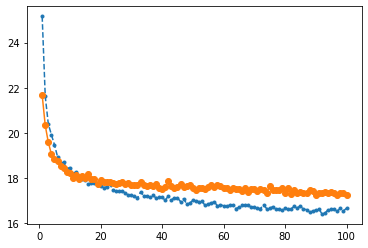

In [152]:
loss = history.history['loss']
epochs = range(1, len(loss) + 1)
val_loss = history.history['val_loss']
plt.plot(epochs, loss, '.--', label='Training loss')
plt.plot(epochs, val_loss, 'o-', label='Validation loss')
plt.show()

               precision    recall  f1-score   support

  class_Snare       0.90      0.83      0.86       645
   class_Kick       0.91      0.89      0.90       468
    class_Hat       0.90      0.74      0.81       389
    class_Tom       0.82      0.84      0.83       377
 class_Cymbal       0.78      0.94      0.85       219
   class_Clap       0.83      0.96      0.89        94
class_Cowbell       0.92      0.96      0.94        46
  class_Conga       0.47      0.78      0.58        36
 class_Shaken       0.42      0.88      0.57        32

     accuracy                           0.85      2306
    macro avg       0.77      0.87      0.80      2306
 weighted avg       0.86      0.85      0.85      2306



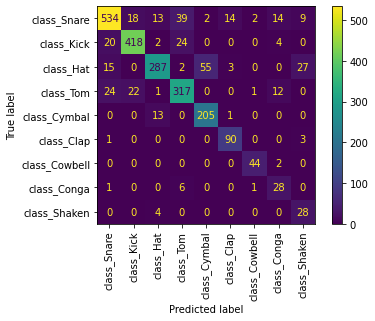

In [153]:
y_pred, y_pred_sub = model_sub.predict([x_vgg_valid, x_yam_valid])
y_pred_class = np.argmax(y_pred,axis=1).astype(int)
conf_matrix = ConfusionMatrixDisplay(
    confusion_matrix(y_valid_class, y_pred_class),
    display_labels=classes_cols,
)
conf_matrix.plot(xticks_rotation=90);
print(classification_report(y_valid_class, y_pred_class, target_names=classes_cols))


Index(['subclass_Cymbal_China', 'subclass_Cymbal_Crash',
       'subclass_Cymbal_Other', 'subclass_Cymbal_Ride',
       'subclass_Cymbal_Splash', 'subclass_Hat_Close', 'subclass_Hat_Foot',
       'subclass_Hat_Open', 'subclass_None', 'subclass_Shaken_Cabasa',
       'subclass_Shaken_Maracas', 'subclass_Shaken_Other',
       'subclass_Shaken_Shaker', 'subclass_Snare_Flam', 'subclass_Snare_Off',
       'subclass_Snare_On', 'subclass_Snare_Rim', 'subclass_Snare_Side'],
      dtype='object')

/home/guillaume/miniconda3/envs/DrumAI/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1945: UserWarning: labels size, 19, does not match size of target_names, 18
  warnings.warn(


                         precision    recall  f1-score   support

  subclass_Cymbal_China       0.22      0.79      0.34        14
  subclass_Cymbal_Crash       0.30      0.73      0.43        71
  subclass_Cymbal_Other       0.00      0.00      0.00        31
   subclass_Cymbal_Ride       0.54      0.24      0.33        92
 subclass_Cymbal_Splash       0.00      0.00      0.00        11
     subclass_Hat_Close       0.31      0.86      0.45       114
      subclass_Hat_Foot       0.00      0.00      0.00        15
      subclass_Hat_Open       0.00      0.00      0.00       260
          subclass_None       0.91      0.95      0.93      1021
 subclass_Shaken_Cabasa       0.00      0.00      0.00        10
subclass_Shaken_Maracas       0.00      0.00      0.00         2
  subclass_Shaken_Other       0.00      0.00      0.00         5
 subclass_Shaken_Shaker       0.19      0.87      0.32        15
    subclass_Snare_Flam       0.00      0.00      0.00         0
     subclass_Snare_Off 

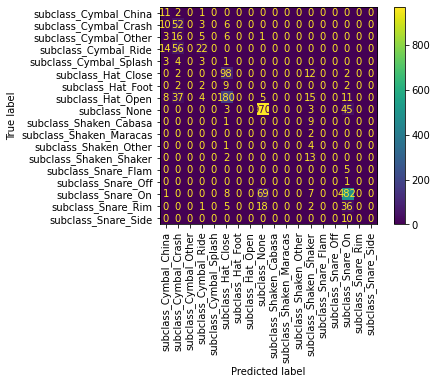

In [160]:
y_valid_subclass = np.argmax(y_valid_sub.values,axis=1).astype(int)
y_pred_subclass = np.argmax(y_pred_sub,axis=1).astype(int)
conf_matrix = ConfusionMatrixDisplay(
    confusion_matrix(y_valid_subclass, y_pred_subclass),
    display_labels=subclasses_cols[np.unique(y_valid_subclass)],
)
conf_matrix.plot(xticks_rotation=90);
print(classification_report(y_valid_subclass, y_pred_subclass, labels=range(19), target_names=subclasses_cols[np.unique(y_valid_subclass)]))


In [ ]:
y_train, y_train_sub

In [ ]:
def show_sub_errors(data, y, y_pred, classes_cols):
    nb_classes = classes_cols.shape[0]
    y_class = np.argmax(y.values,axis=1).astype(int)
    for i in range(nb_classes):
        for j in range(nb_classes):
            if i == j:
                continue
            true_index = np.where(y_class==i)[0]
            pred_index = np.where(np.argmax(y_pred,axis=1).astype(int) == j)[0]
            index = list(set(true_index.tolist()) & set(pred_index.tolist()))
            if (len(index)==0):
                continue
            confidence = y_pred[index,j]
            index = index[np.argmax(confidence)]
            confidence = y_pred[index,j]
            index = y.iloc[[index]].index
            print(f'true: {classes_cols[i]}')
            print(f'pred: {classes_cols[j]}')
            print(f'confidence: {confidence}')
            path = data.loc[index, 'path'].values[0]
            print(path)
            sound, sr = load(path)
            IPython.display.display(IPython.display.Audio(sound, rate=sr, autoplay=False))

In [ ]:
show_sub_errors(data, y_train, y_pred, classes_cols)

In [ ]:
show_sub_errors(data, y_train_sub, y_pred_sub, subclasses_cols)

In [ ]:
y_pred_sub[0]